https://www.kaggle.com/datasets/andrewmvd/spotify-playlists?select=spotify_dataset.csv

In [1]:
# libraries

import random
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import tensorflow as tf
#!pip install node2vec
from node2vec import Node2Vec
import matplotlib.pyplot as plt
from collections import defaultdict
import community.community_louvain as louvain

In [2]:
# for Colab - ignore

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# data set import

spotify_playlist_raw =  pd.read_csv("drive/MyDrive/spotify_dataset.csv",on_bad_lines='skip',
                                names=['user_id', 'artist', 'track', 'playlist'])

In [ ]:
spotify_playlist_raw.head()

,user_id,artist,track,playlist
0,user_id,"""artistname""","""trackname""","""playlistname"""
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010


In [ ]:
spotify_playlist_raw.shape

(12891681, 4)

In [4]:
# too many rows - sampling

rows = 125000
spotify_playlist = spotify_playlist_raw.sample(n=rows,random_state=14)

In [ ]:
# missing values

spotify_playlist.isnull().sum(axis=0)/spotify_playlist.shape[0]

user_id     0.000000
artist      0.002704
track       0.000000
playlist    0.000072
dtype: float64

In [5]:
# dropna

spotify_playlist_no_null = spotify_playlist.dropna()

In [6]:
# only useful columns

data = spotify_playlist_no_null.drop(['track','playlist'],axis=1)

In [7]:
# no multiple times same user-artist

df_unique = data.drop_duplicates(subset=['user_id','artist'])

pairs_unique = df_unique['artist'].value_counts()

pairs_unique.head()

Coldplay      298
Daft Punk     288
JAY Z         268
Kanye West    252
Radiohead     237
Name: artist, dtype: int64

In [ ]:
df_unique.shape

(109537, 2)

In [8]:
# how many times two artist has been listened to by an user

pairs = defaultdict(int)

# Loop through the entire list of users
for group in df_unique.groupby("user_id"):
    # List of artists rated by the current user
    user_artists = list(group[1]["artist"])


    # Count every time two artists are listened to together
    for i in range(len(user_artists)):
        for j in range(i+1, len(user_artists)):
            pairs[(user_artists[i], user_artists[j])] += 1

In [9]:
# let's create the network

G = nx.Graph()

# Try to create an edge between artists that are listened to together
for pair in pairs:
    artist1, artist2 = pair
    if artist1 != artist2:
      score = pairs[pair]

    # The edge is only created when the score is high enough -> at least 2 users have listened to the pair
      if score >= 2:
        G.add_edge(artist1, artist2, weight=score)

print("Total number of graph nodes:", G.number_of_nodes())
print("Total number of graph edges:", G.number_of_edges())

Total number of graph nodes: 5586
Total number of graph edges: 70430


In [ ]:
# GRAPH PROPERTIES

degrees = list(dict(G.degree()).values())

In [ ]:
# statistics about degrees

avg_degree = np.mean(degrees)
min_degree = np.min(degrees)
max_degree = np.max(degrees)
std_dev_degree = np.std(degrees)
median_degree = np.median(degrees)

print("Mean:", avg_degree,"\nMinimum:", min_degree, "\nMaximum:", max_degree,"\nStandard Deviation:", std_dev_degree,"\nMedian:", median_degree)

Mean: 25.216612960973862 
Minimum: 1 
Maximum: 771 
Standard Deviation: 62.37144013595095 
Median: 5.0


In [ ]:
# density

density = nx.density(G)
density

0.004515060512260315

In [10]:
# degree centrailty
degree_centrality = nx.degree_centrality(G)
degree_central = max(degree_centrality,key=degree_centrality.get)

In [ ]:
# closeness centrailty
closeness_centrality = nx.closeness_centrality(G)
close_central = max(closeness_centrality,key=closeness_centrality.get)

# betweenness centrality
betw_centrality = nx.betweenness_centrality(G)
betw_central = max(betw_centrality,key=betw_centrality.get)

# eigenvector centrality
eigen_centrality = nx.eigenvector_centrality(G)
eigen_central = max(eigen_centrality,key=eigen_centrality.get)

print("Most central nodes according to the following definitions:","\nDegree:", degree_central,"\nCloseness", close_central,"\nBetweenness:", betw_central,"\nEigenvector:", eigen_central)

Most central nodes according to the following definitions: 
Degree: David Bowie 
Closeness Coldplay 
Betweenness: David Bowie 
Eigenvector: Radiohead


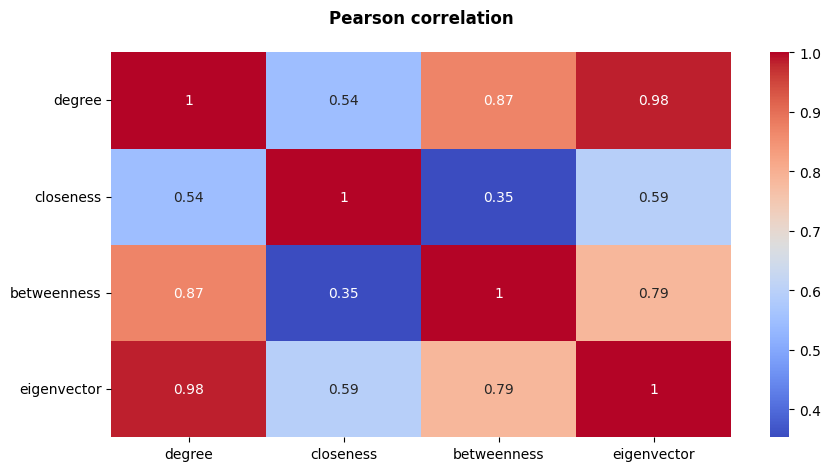

In [ ]:
all_centr = [degree_centrality,closeness_centrality,betw_centrality,eigen_centrality]
corrs = [[scipy.stats.pearsonr(list(c1.values()), list(c2.values()))[0] for c1 in all_centr] for c2 in all_centr]
centralities = ['degree', 'closeness','betweenness','eigenvector']
plt.figure(figsize = (10,5))
sns.heatmap(pd.DataFrame(corrs),annot = True,cmap = 'coolwarm')
plt.xticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.yticks([x+0.5 for x in range(4)],centralities, rotation = 0)
plt.title('Pearson correlation\n', weight = 'bold')
plt.show()

In [11]:
sort_degree_centrality = dict(sorted(degree_centrality.items(),key=lambda item:item[1],reverse=True))
top_degree = list(sort_degree_centrality.keys())[:5]

In [ ]:
sort_close_centrality = dict(sorted(closeness_centrality.items(),key=lambda item:item[1],reverse=True))
top_close = list(sort_close_centrality.keys())[:5]
sort_betw_centrality = dict(sorted(betw_centrality.items(),key=lambda item:item[1],reverse=True))
top_betw = list(sort_betw_centrality.keys())[:5]
sort_eigen_centrality = dict(sorted(eigen_centrality.items(),key=lambda item:item[1],reverse=True))
top_eigen = list(sort_eigen_centrality.keys())[:5]
print("Top 5 nodes according to:\nDegree centrality:", top_degree,"\nCloseness:", top_close,"\nBetweenness", top_betw,"\nEigenvector:", top_eigen)

Top 5 nodes according to:
Degree centrality: ['David Bowie', 'JAY Z', 'Coldplay', 'Radiohead', 'Queen'] 
Closeness: ['Coldplay', 'Radiohead', 'JAY Z', 'David Bowie', 'Queen'] 
Betweenness ['David Bowie', 'JAY Z', 'Daft Punk', 'Coldplay', 'Queen'] 
Eigenvector: ['Radiohead', 'Coldplay', 'JAY Z', 'David Bowie', 'Queen']


In [ ]:
# Connectivity

nx.is_connected(G)

False

In [ ]:
nx.number_connected_components(G)

40

In [ ]:
len_components = [len(c) for c in nx.connected_components(G)]
components = [c for c in nx.connected_components(G)]

In [ ]:
# largest connected component

lcc = G.subgraph(components[0])
print(lcc.number_of_nodes())
print(lcc.number_of_edges())
avg_shrt_path_len_lcc = nx.average_shortest_path_length(lcc)
print(avg_shrt_path_len_lcc)
diam_lcc = nx.diameter(lcc)
print(diam_lcc)

5503
70386
3.0523421579042873
8


In [ ]:
degrees_lcc = list(dict(lcc.degree()).values())
avg_degree_lcc = np.mean(degrees_lcc)
print(avg_degree_lcc)
density_lcc = nx.density(lcc)
print(density_lcc)

25.580955842267855
0.004649392192342394


In [ ]:
largest_component = len_components[0]/sum(len_components)
largest_component

0.9851414249910491

In [ ]:
components_count = defaultdict(int)

for comp in len_components:
  components_count[comp] +=1

components_count

defaultdict(int, {5503: 1, 2: 35, 3: 3, 4: 1})

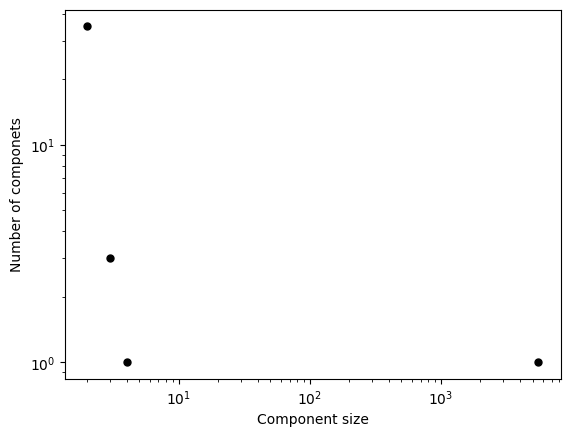

In [ ]:
plt.plot(components_count.keys(),components_count.values(),'o',markersize=5,color='black')

plt.xlabel('Component size')
plt.ylabel('Number of componets')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
# bridges

print(nx.has_bridges(G))
bridges = len(list(nx.bridges(G,root=None)))
print(bridges)
perc_bridge = bridges/G.number_of_edges()
print(perc_bridge)

True
1374
0.019508732074400112


In [ ]:
# how many nodes have a certain degree

degrees = list(dict(G.degree()).values())

degree_count = defaultdict(int)

for degree in degrees:
 degree_count[degree] +=1

In [ ]:
# sorting

degree_count = dict(sorted(degree_count.items()))

In [ ]:
# dividing by 1/N

p_k = []

for degree in degree_count.values():
  p_k.append(degree/sum(degree_count.values()))

In [ ]:
# 1-cdf

cp_k = np.cumsum(p_k)
eccdf = [1-cumu for cumu in cp_k]

In [ ]:
# random model to compare

random_network = nx.fast_gnp_random_graph(G.order(),density)

In [ ]:
random_nodes = random_network.order()
random_edges = random_network.size()
print("Random nodes:", random_nodes,"\nRandom edges:", random_edges)

Random nodes: 5586 
Random edges: 70976


In [ ]:
# same operations as before on the random graph

random_degrees = list(dict(random_network.degree()).values())

random_count = defaultdict(int)

for degree in random_degrees:
 random_count[degree] +=1

random_count = dict(sorted(random_count.items()))

rand_p_k = []

for degree in random_count.values():
  rand_p_k.append(degree/sum(random_count.values()))

rand_cp_k = np.cumsum(rand_p_k)
rand_eccdf = [1-cumu for cumu in rand_cp_k]

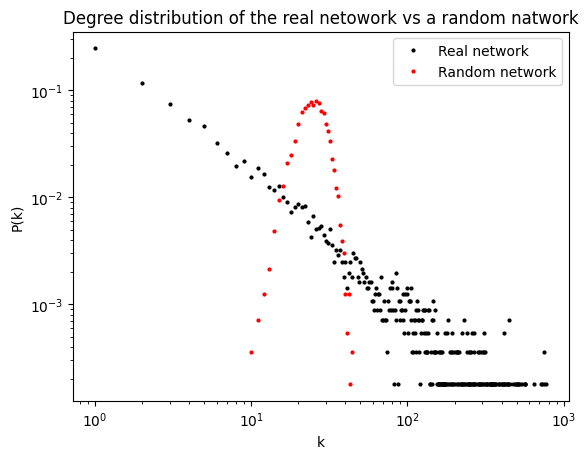

In [ ]:
# first plot

plt.plot(degree_count.keys(),p_k,'o',markersize=2,color='black')
plt.plot(random_count.keys(),rand_p_k,'o',markersize=2,color='red')

plt.title('Degree distribution of the real netowork vs a random natwork')
plt.legend(['Real network','Random network'])
plt.xlabel('k')
plt.ylabel('P(k)')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
plot_degree = list(degree_count.keys()) # otherwise problems
rand_plot_degree = list(random_count.keys()) # otherwise problems

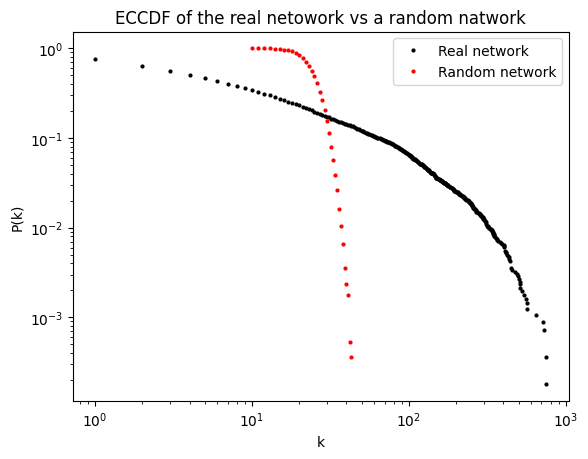

In [ ]:
# second plot

plt.plot(plot_degree[:len(plot_degree)-1],eccdf[:len(eccdf)-1],'o',markersize=2,color='black')

plt.plot(rand_plot_degree[:len(rand_plot_degree)-1],rand_eccdf[:len(rand_eccdf)-1],'o',markersize=2,color='red')

plt.title('ECCDF of the real netowork vs a random natwork')
plt.legend(['Real network','Random network'])
plt.xlabel('k')
plt.ylabel('P(k)')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
# assortativity

assortativity = nx.degree_assortativity_coefficient(G)
print(assortativity)

-0.13464351282958514


In [ ]:
# transitivity - gcc and avg lcc

gcc = nx.transitivity(G)
avg_lcc = nx.average_clustering(G)

print("Global clustering coefficient:", gcc,"\nAverage local clustering coefficient:", avg_lcc)

Global clustering coefficient: 0.19194790824360555 
Average local clustering coefficient: 0.3634167928162059


In [ ]:
seed = 42
np.random.seed(seed)

In [ ]:
#community

partitions = louvain.best_partition(G) # every node and its community

In [ ]:
list_comms = defaultdict(set)

for node,comm in partitions.items():
  list_comms[comm].add(node)

In [ ]:
n_comms = len(list_comms)
n_comms

49

In [ ]:
# how many node in each community

len_list_comms = defaultdict(int)

for comm,set_ in list_comms.items():
  len_list_comms[comm]=len(set_)

In [ ]:
comms_nodes = list(len_list_comms.values())

avg_comm = np.mean(comms_nodes)
min_comm = np.min(comms_nodes)
max_comm = np.max(comms_nodes)

print("Mean:", avg_comm,"\nMinimum:", min_comm, "\nMaximum:", max_comm)

Mean: 114.0 
Minimum: 2 
Maximum: 1527


In [ ]:
comms_count = defaultdict(int)

for comm in comms_nodes:
  comms_count[comm] +=1

In [ ]:
# sorting
comms_count = dict(sorted(comms_count.items()))
comms_count

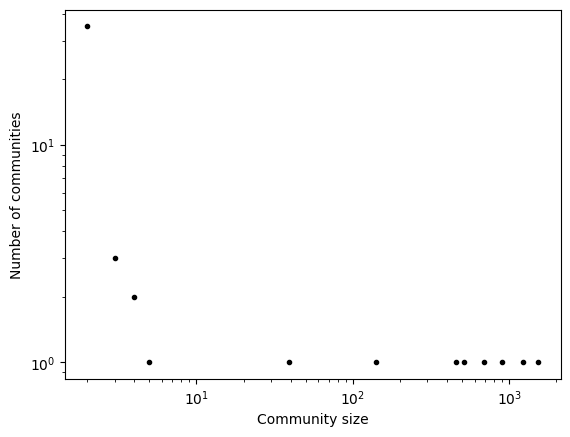

In [ ]:
plt.plot(comms_count.keys(),comms_count.values(),'o',markersize=3,color='black')

plt.xlabel('Community size')
plt.ylabel('Number of communities')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
comms_top = []
print(top_degree)

for node in top_degree: # centrality lists are the same
  comms_top.append(partitions[node])

comms_top

['David Bowie', 'JAY Z', 'Coldplay', 'Radiohead', 'Queen']


[3, 0, 2, 2, 3]

In [ ]:
# ML PART - NODE2VEC - RECOMMENDATION SYSTEM

#DFS

node2vec = Node2Vec(G,dimensions=64,walk_length=30,num_walks=500,p=2,q=1,workers=2)
model = node2vec.fit(window=6,min_count=1,batch_words=3)

def recommend(singer):

  artists = []

  for artist in model.wv.most_similar(str(singer))[:5]:
      artists.append(artist)

  print(artists)

recommend("Radiohead")
recommend("Coldplay")
recommend("David Bowie")

Computing transition probabilities:   0%|          | 0/5586 [00:00<?, ?it/s]

[('Esther Phillips', 0.953582763671875), ('...And You Will Know Us By The Trail Of Dead', 0.9488362669944763), ('2 LIVE CREW', 0.9465721249580383), ('Zoe Keating', 0.9439899921417236), ('Irma Thomas', 0.9423037171363831)]
[('Guru Josh Project', 0.961673378944397), ('Sr. Chinarro', 0.9594983458518982), ('The Concretes', 0.9588379859924316), ('Lisa Hannigan', 0.9586614966392517), ('Approaching Nirvana', 0.9584906697273254)]
[('Robert Hood', 0.9599379897117615), ('Little Willie John', 0.9587134718894958), ('Patti Page', 0.9570356011390686), ('J.J. Cale', 0.956867516040802), ('Canterbury', 0.9554817080497742)]


In [ ]:
bottom_degree = list(sort_degree_centrality.keys())[-5:]

In [ ]:
for node in bottom_degree:
  recommend(node)

[('50 Cent', 0.9701106548309326), ('Foxy Brown', 0.9557238817214966), ('Vybz Kartel', 0.6814218759536743), ('Demarco', 0.6760348677635193), ('Terrace Martin', 0.6757627725601196)]
[('Rush', 0.9711724519729614), ('A Pale Horse Named Death', 0.9699565768241882), ('Hoodoo Gurus', 0.9578256607055664), ('Corrosion Of Conformity', 0.8708930015563965), ('Camel', 0.7721099853515625)]
[('Daryl Hall & John Oates', 0.9732545614242554), ('Brian May', 0.8343746066093445), ('Black Star', 0.6060977578163147), ('Smash Mouth', 0.5456985831260681), ('Alphaville', 0.5416000485420227)]
[('Kendrick Lamar', 0.9664266109466553), ('Evidence', 0.9616841673851013), ('Ryuichi Sakamoto', 0.9576336145401001), ('Autre Ne Veut', 0.9554238319396973), ('Mark Kozelek', 0.9504005312919617)]
[('Ojos de Brujo', 0.9669814705848694), ('The Smashing Pumpkins', 0.9622058272361755), ('Animals As Leaders', 0.9570116400718689), ("K's Choice", 0.9551040530204773), ('Andy Williams', 0.9413436055183411)]


In [12]:
# ML PART - NODE2VEC - RECOMMENDATION SYSTEM

# BFS

node2vec = Node2Vec(G,dimensions=64,walk_length=30,num_walks=500,p=1,q=2,workers=2)
model = node2vec.fit(window=6,min_count=1,batch_words=3)

def recommend(singer):

  artists = []

  for artist in model.wv.most_similar(str(singer))[:5]:
      artists.append(artist)

  print(artists)

recommend("Radiohead")
recommend("Coldplay")
recommend("David Bowie")

bottom_degree = list(sort_degree_centrality.keys())[-5:]
for node in bottom_degree:
  recommend(node)

Computing transition probabilities:   0%|          | 0/5586 [00:00<?, ?it/s]

[('Irma Thomas', 0.9591031074523926), ('...And You Will Know Us By The Trail Of Dead', 0.9561775922775269), ('Esther Phillips', 0.9532853960990906), ('Zoe Keating', 0.9479573369026184), ('2 LIVE CREW', 0.9458306431770325)]
[('Conor Maynard', 0.9675903916358948), ('Turisas', 0.9648023247718811), ('Seabird', 0.9618701338768005), ("Pickin' On Series", 0.9612242579460144), ('Sr. Chinarro', 0.9590392112731934)]
[('Nils Petter Molvær', 0.9771271347999573), ('Frankie Goes To Hollywood', 0.9731791615486145), ('Odyssey', 0.9679949283599854), ('David Lanz', 0.965610146522522), ('Patti Page', 0.9652543067932129)]
[('50 Cent', 0.9763683676719666), ('Foxy Brown', 0.9680736660957336), ('Terrace Martin', 0.709716796875), ('Vybz Kartel', 0.70524662733078), ('Demarco', 0.6667007207870483)]
[('Rush', 0.968698263168335), ('Hoodoo Gurus', 0.9622723460197449), ('A Pale Horse Named Death', 0.9589534401893616), ('Corrosion Of Conformity', 0.8398126363754272), ('Camel', 0.7753439545631409)]
[('Daryl Hall & Jo